In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np

file_path = './test_files/3Dblood27.11.txt'
df = pd.read_csv(file_path, header=None)
df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
df

,x,y,z,r,g,b
0,4.300000,11.197390,3.047941,0,0,0
1,4.200000,11.197390,3.047941,0,0,0
2,4.100000,11.197390,3.047941,0,0,0
3,4.000000,11.197390,3.047941,0,0,0
4,3.900000,11.197390,3.047941,0,0,0
...,...,...,...,...,...,...
1799,4.324351,10.356519,3.886832,255,0,255
1800,4.253031,10.706822,3.538061,255,0,255
1801,4.260648,10.636221,3.608462,255,0,255
1802,4.295052,11.128907,3.116422,255,0,255


In [4]:
def distance_calculator(df):
    # Drop NaN values (usually the first value)
    dx = df['x'].diff()
    dy = df['y'].diff()
    dz = df['z'].diff()

    # Calculate the Euclidean distance between consecutive rows
    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    df['distance_from_last'] = distances
    return df

def remove_overlap(shape):
    # Checks for any large jumps at the end of a line and, if found, moves the last row to the top
    # This hopefully removes the jump and makes the line continuous
    # Note this seems very fragile and I probably need add a second check for large jumps at the end of the code
    if shape.iloc[-1]['distance_from_last'] > 2.:
        # Move the last row to the top
        last_row = shape.iloc[[-1]]  # Select the last row as a DataFrame
        remaining_rows = shape.iloc[:-1]  # Select all rows except the last
        shape = pd.concat([last_row, remaining_rows]).reset_index(drop=True)

    shape = distance_calculator(shape)
    return shape

def midlinejumpsplitter(shape):
    # This needs generalising to lines with more than 2 jumps
    print('Splitting line with id:', shape['line_id'].unique()[0])
    id = shape['line_id'].unique()[0]
    # Split the line at the index - at the moment uses a completely arbitrary distance of 2mm
    split_index = shape[shape['distance_from_last'] > 2.].index[0]
    shape1 = shape.iloc[:split_index]
    shape1['line_id'] = 1
    shape1['distance_from_last'].iloc[0] = np.nan
    shape2 = shape.iloc[split_index:]
    shape2['line_id'] = 2
    shape2['distance_from_last'].iloc[0] = np.nan
    return shape1, shape2

def shapesplitter(df):
    # Identify line IDs that have large jumps in the middle
    line_ids = np.sort(df['line_id'].unique())   # Sorting makes life easier later
    line_ids_new = line_ids.copy()   # A list of line IDs that we're going to update
    for line_id in line_ids:
        shape = df[df['line_id'] == line_id]
        if shape['distance_from_last'].max() > 2.:
            shape1, shape2 = midlinejumpsplitter(shape)
            df, line_ids_new = df[df['line_id'] != line_id], line_ids_new[line_ids_new != line_id]
            line_ids_new = np.append(line_ids_new, [line_ids_new[-1]+1, line_ids_new[-1]+2])
            shape1['line_id'], shape2['line_id'] = line_ids_new[-2], line_ids_new[-1]
            shape = pd.concat([shape1, shape2])
            df = pd.concat([df, shape])
    return df

df = distance_calculator(df)
# Initially, identify distinct lines by their RGB values
df['line_id'] = pd.factorize(df[['r','g','b']].apply(tuple, axis=1))[0]
# Remove large jumps at the end of lines
df = df.groupby('line_id', group_keys=False).apply(remove_overlap)
df = distance_calculator(df)

# Set distance from last to NaN for the first row of each line
df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan

# Find and split lines that have big jumps in the middle, e.g., inlet and outlet lines
shapesplitter(df)




Splitting line with id: 0


,x,y,z,r,g,b,distance_from_last,line_id
88,18.173898,11.206091,2.920448,0,255,0,NaN,1
89,18.130112,11.205503,2.830550,0,255,0,0.099996,1
90,18.083607,11.204930,2.742028,0,255,0,0.099996,1
91,18.034410,11.204372,2.654973,0,255,0,0.099996,1
92,17.982553,11.203830,2.569476,0,255,0,0.099996,1
...,...,...,...,...,...,...,...,...
83,22.100492,11.206475,2.978680,0,0,0,0.100000,10
84,22.200492,11.206475,2.978680,0,0,0,0.100000,10
85,22.300492,11.206475,2.978680,0,0,0,0.100000,10
86,22.400492,11.206475,2.978680,0,0,0,0.100000,10


In [5]:
pd.set_option('display.max_rows', 500)
df[df['line_id'] == 3]

,x,y,z,r,g,b,distance_from_last,line_id
446,18.077385,11.126517,2.864335,0,255,255,NaN,3
447,18.137023,11.172639,2.930032,0,255,255,0.100000,3
448,18.018336,11.079791,2.798533,0,255,255,0.199998,3
449,18.077385,11.126517,2.864335,0,255,255,0.100000,3
450,17.959917,11.032413,2.732635,0,255,255,0.199997,3
451,18.018336,11.079791,2.798533,0,255,255,0.100000,3
452,17.678890,10.783779,2.402283,0,255,255,0.599884,3
453,17.733444,10.835296,2.468387,0,255,255,0.099999,3
454,17.470779,10.566051,2.139178,0,255,255,0.499864,3
455,17.521163,10.622457,2.204597,0,255,255,0.099998,3


In [57]:
shape = df[df['line_id'] == 4]
shape['line_id'].unique()[0]

4

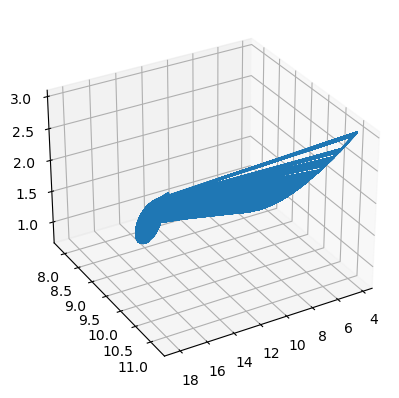

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# for n in np.unique(df['line_id'].values):
#     ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

# If you need a specific line plotting
n = 2
ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

# for n in np.unique(terminal_points['cluster'].values):
#     ax.scatter(terminal_points[terminal_points['cluster'] == n]['x'], terminal_points[terminal_points['cluster'] == n]['y'], terminal_points[terminal_points['cluster'] == n]['z'])

ax.view_init(elev=30, azim=60)  # Elevation of 30 degrees, azimuth of 45 degrees
plt.show()



In [12]:
df[df['line_id'] == 0]

,x,y,z,r,g,b,distance_from_last,line_id
0,4.275980,11.059498,3.185819,255,0,255,NaN,0
1,4.295052,11.128907,3.116422,255,0,255,0.099987,0
2,4.260648,10.636221,3.608462,255,0,255,0.697156,0
3,4.253031,10.706822,3.538061,255,0,255,0.099995,0
4,4.324351,10.356519,3.886832,255,0,255,0.499439,0
...,...,...,...,...,...,...,...,...
225,18.153788,10.878121,3.298834,255,0,255,0.099995,0
226,18.174472,11.022778,3.162338,255,0,255,0.199961,0
227,18.165722,10.950724,3.231118,255,0,255,0.099995,0
228,18.179940,11.094141,3.092508,255,0,255,0.199959,0


In [ ]:
# Next bit is to use hierarchical clustering to note common start / end points
# Gather the first and last points of each line:
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
start_points = df.groupby('line_id', group_keys=False).first()  # First point of each line
end_points = df.groupby('line_id', group_keys=False).last()  # Last
terminal_points = pd.concat([start_points, end_points])   
dist_mat = dist.pdist(terminal_points[['x', 'y', 'z']].values)   
link_mat = hier.linkage(dist_mat)
# fcluster assigns each of the particles in positions a cluster to which it belongs
cluster_idx = hier.fcluster(link_mat, t=1, criterion='distance')   # t defines the max cophonetic distance in a cluster
terminal_points['cluster'] = cluster_idx

# Calculate the cluster start and end points 

In [20]:
def determine_style(row):
    # capillaries
    if row['b'] > 0:
        return 2
    # venules
    elif row['g'] > 0:
        return 5
    # veins 
    elif row['r'] > 0:
        return 8 
    else:
        return 1

def thickness_to_radius(thickness):
    # Assuming radius is proportional to thickness
    return thickness / 2

# Apply determine_style to get thickness
df['thickness'] = df.apply(determine_style, axis=1)

# Convert thickness to radius3
df['radius'] = df['thickness'].apply(thickness_to_radius)

df['e'] = np.pi * df['radius']**2 * df['distance_to_next']

df

,x,y,z,r,g,b,distance_to_next,thickness,radius,e
0,0.900000,0.000000,0.0,200,0,0,NaN,8,4.0,NaN
1,1.000000,0.000000,0.0,200,0,0,0.100000,8,4.0,5.026548
2,-0.900000,0.000000,0.0,200,0,0,1.900000,8,4.0,95.504417
3,-1.000000,0.000000,0.0,200,0,0,0.100000,8,4.0,5.026548
4,0.639206,-0.316260,0.0,0,255,0,1.669435,5,2.5,32.779289
...,...,...,...,...,...,...,...,...,...,...
190,-0.087749,-0.012726,0.0,0,0,255,0.014130,2,1.0,0.044391
191,-0.100991,-0.006839,0.0,0,0,255,0.014491,2,1.0,0.045526
192,-0.114177,0.000032,0.0,0,0,255,0.014869,2,1.0,0.046712
193,-0.127244,0.007937,0.0,0,0,255,0.015272,2,1.0,0.047979


In [21]:
def generate_gcode(df):
    gcode_lines = []

    # Define some starting commands if necessary
    gcode_lines.append("G21 ; Set units to millimeters")
    gcode_lines.append("G90 ; Absolute positioning")
    
    for index, row in df.iterrows():
        # Move to the start position
        gcode_lines.append(f"G0 X{row['x']} Y{row['y']} Z{row['z']} ; Move to start position")
        
        # Example of drawing or other operation
        # For simplicity, let's assume 'e' is used for setting extrusion or other properties
        gcode_lines.append(f"G1 E{row['e']} ; Set extrusion amount")
        
        # Move to another position or perform an action (for demonstration)
        gcode_lines.append(f"G1 X{row['x']+5} Y{row['y']} Z{row['z']} ; Move to another position")
    
    # Add end commands if necessary
    gcode_lines.append("M30 ; End of program")

    return "\n".join(gcode_lines)

# Generate the G-code
gcode = generate_gcode(df)

# Save to a file
with open("output.gcode", "w") as file:
    file.write(gcode)